In [1]:
import pandas as pd
from scipy.fftpack import fft, rfft
from matplotlib import pyplot as plt 
import numpy as np
from scipy.signal import windows
import matplotlib.dates as mdates

### Data Prep

In [2]:
# Load data set 
all_merged_data = pd.read_csv("all_merged_data.csv")

In [3]:
sample_size_test = int(all_merged_data.shape[1] * 0.1)  # Calculate 10% of the columns

# Randomly select 10% of the columns
sampled_columns_test = all_merged_data.sample(n=sample_size_test, axis=1, random_state=42)  # Use random_state for reproducibility

# Separate the sampled columns as test columns and the rest as train columns
train = all_merged_data.drop(columns=sampled_columns_test.columns)  # Remaining 90% of columns
test = sampled_columns_test  # 10% of randomly selected columns
test['date'] = all_merged_data['date']  # Add 'date' back to test
train['date'] = all_merged_data['date']  # Add 'date' back to train


sample_size_dev = int(train.shape[1] * 0.1)  # Calculate 10% of the columns
# Randomly select 10% of the columns
sampled_columns_dev = train.sample(n=sample_size_dev, axis=1, random_state=42)  # Use random_state for reproducibility

# Separate the sampled columns as dev columns and the rest as true train columns
train = train.drop(columns=sampled_columns_dev.columns)  # Remaining 90% of columns
dev = sampled_columns_dev  # 10% of randomly selected columns

In [4]:
# removing the mean from the data to minimize distortion in the lower frequencies 
X = (dev['Tire chains'] - dev['Tire chains'].mean()).values

In [5]:
dates = pd.to_datetime(train['date'])


# Compute the FFT
fft_result = np.fft.fft(X)
freqs = np.fft.fftfreq(len(fft_result), 1)

# Identify the positive frequencies and their magnitudes
positive_freqs = freqs[:len(freqs)//2]
positive_magnitude = np.abs(fft_result[:len(fft_result)//2])

# Find the index of the highest magnitude frequency
max_index = np.argmax(positive_magnitude)
dominant_freq = positive_freqs[max_index]

# Create a mask to isolate the frequency with the highest magnitude
mask = np.zeros_like(fft_result, dtype=complex)
mask[max_index] = fft_result[max_index]
mask[-max_index] = fft_result[-max_index]  # Include the symmetric part for real signals

# Perform IFFT to reconstruct the signal for the highest magnitude frequency
reconstructed_signal = np.fft.ifft(mask).real

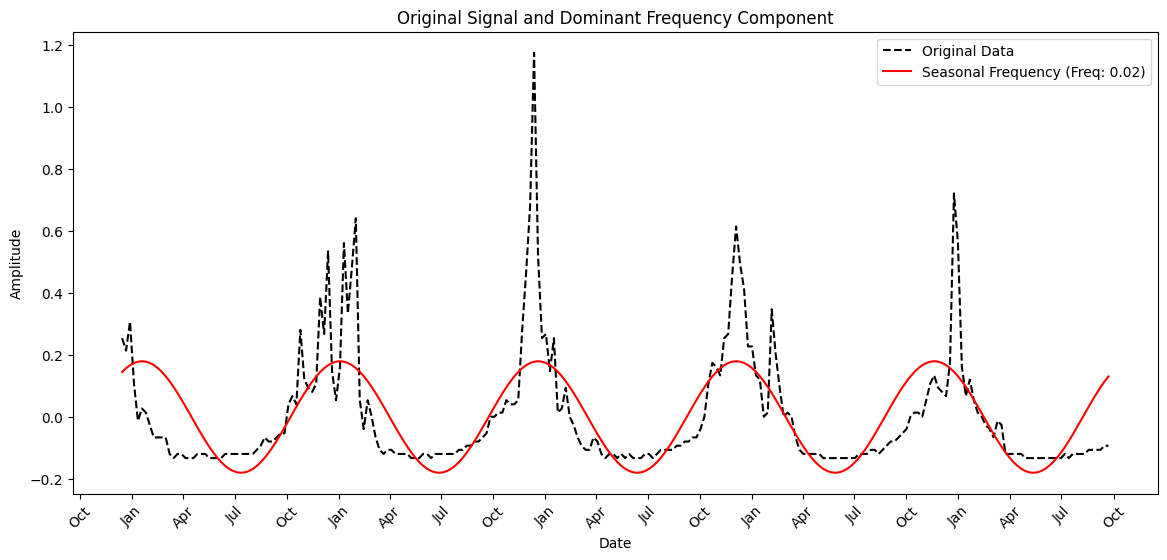

In [6]:
# Plot the original signal and the highest magnitude frequency component with the date as x-axis
plt.figure(figsize=(14, 6))
plt.plot(dates, X, label="Original Data", linestyle='--', color='black')
plt.plot(dates, reconstructed_signal, label=f"Seasonal Frequency (Freq: {dominant_freq:.2f})", color='red')

# Set the title and labels
plt.title("Original Signal and Dominant Frequency Component")
plt.xlabel("Date")
plt.ylabel("Amplitude")

# Set x-axis locator to show quarterly ticks (one tick per 3 months)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(bymonthday=15, interval=3))  # Major ticks every 3 months (quarterly)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))  # Format as month abbreviation (e.g., Jan, Apr, Jul)

# Optionally, you can add minor ticks if needed, but they aren't necessary for your case
# plt.gca().xaxis.set_minor_locator(mdates.MonthLocator(bymonthday=15, interval=1))  # Minor ticks every month

# Rotate the x-axis labels for better visibility
plt.xticks(rotation=45)

# Display the legend
plt.legend()

# Show the plot
plt.show()

In [7]:
# Frequency found from FFT (e.g., 0.04 cycles per week)

# Check if the frequency is non-zero
if dominant_freq > 0:
    # Calculate the period in weeks (1/frequency)
    period_in_weeks = 1 / dominant_freq

    # Convert weeks to months (approximately 4.345 weeks per month)
    period_in_months = period_in_weeks / 4.345

    # Print human-readable cycle description
    if period_in_weeks < 4:
        print(f"The dominant cycle occurs every {period_in_weeks:.2f} weeks.")
    else:
        print(f"The dominant cycle occurs every {period_in_months:.2f} months.")
else:
    print("The frequency is zero or invalid; no cycle can be determined.")

The dominant cycle occurs every 11.51 months.


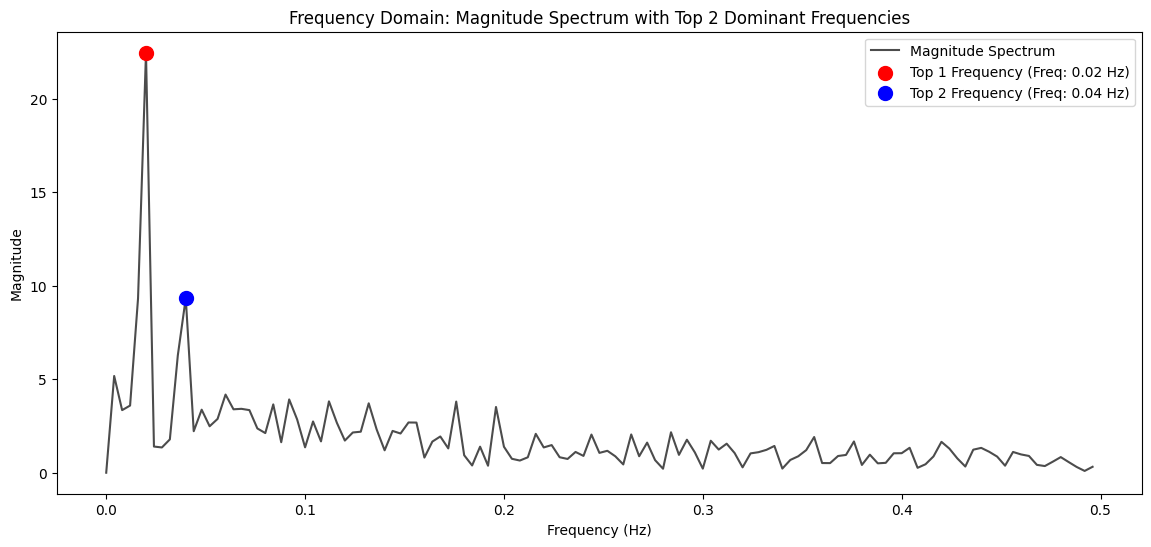

In [8]:
# Find the indices of the top 3 dominant frequencies (highest magnitudes)
top_indices = np.argsort(positive_magnitude)[-2:][::-1]  # Sort and get the top 3

# Plot the frequency domain
plt.figure(figsize=(14, 6))

# Plot the magnitude of all positive frequencies
plt.plot(positive_freqs, positive_magnitude, label="Magnitude Spectrum", color='black', alpha=0.7)

# Highlight the top 3 frequencies with different colors
for i, idx in enumerate(top_indices):
    plt.scatter(positive_freqs[idx], positive_magnitude[idx], label=f"Top {i+1} Frequency (Freq: {positive_freqs[idx]:.2f} Hz)", s=100, color=['red', 'blue'][i], zorder=5)

# Set labels and title
plt.title("Frequency Domain: Magnitude Spectrum with Top 2 Dominant Frequencies")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")

# Add a legend
plt.legend()

# Display the plot
plt.show()


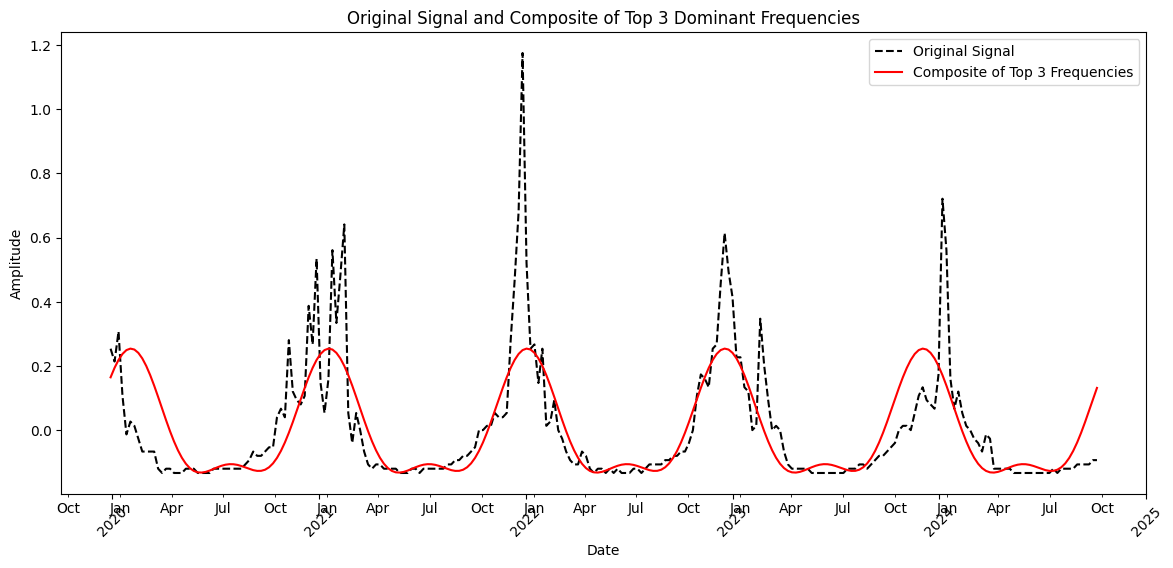

In [9]:
# Reconstruct the signal from the top 3 frequencies
reconstructed_signals = []
for idx in top_indices:
    mask = np.zeros_like(fft_result, dtype=complex)
    mask[idx] = fft_result[idx]
    mask[-idx] = fft_result[-idx]  # Include the symmetric part for real signals
    reconstructed_signals.append(np.fft.ifft(mask).real)

# Sum the top 3 reconstructed signals to get the composite signal
composite_signal = np.sum(reconstructed_signals, axis=0)

# Plot the original signal and the composite signal of the top 3 frequencies
plt.figure(figsize=(14, 6))
plt.plot(dates, X, label="Original Signal", linestyle='--', color='black')
plt.plot(dates, composite_signal, label="Composite of Top 3 Frequencies", color='red')

# Set labels and title
plt.title("Original Signal and Composite of Top 3 Dominant Frequencies")
plt.xlabel("Date")
plt.ylabel("Amplitude")

# Set x-axis formatting with yearly and quarterly ticks
plt.gca().xaxis.set_major_locator(mdates.YearLocator())  # Major ticks every year
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Show year labels only
plt.gca().xaxis.set_minor_locator(mdates.MonthLocator(bymonthday=15, interval=3))  # Minor ticks every 3 months (quarterly)
plt.gca().xaxis.set_minor_formatter(mdates.DateFormatter('%b'))  # Show month abbreviations for minor ticks

# Rotate the x-axis labels for better visibility
plt.xticks(rotation=45)

# Display the legend
plt.legend()

# Show the plot
plt.show()
